In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [ ]:
data = pd.read_csv('../../../data/adult.data.csv')

## Drop categorical features
data = data.drop(['fnlwgt','education'],axis=1)

## Drop NULL values
data = data.dropna()

## for dowhy

data['Probability'] = np.where(data['Probability'] == " <=50K", 0, 1)
data['sex'] = np.where(data['sex'] == " Male", 1, 0)
data['race'] = np.where(data['race'] == " White", 1, 0)

non_numeric_columns = list(data.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    data[col] = le.fit_transform(data[col])

print(non_numeric_columns)

from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)


## Reduce the data size to take a smaller sample

dataset_orig = data.sample(5000)
protected_attribute = "sex"

dataset_orig.head(10)

# Transform data using Reweighing

In [9]:
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.datasets import BinaryLabelDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy

dataset_orig_train,dataset_orig_test = train_test_split(dataset_orig,test_size=0.2,random_state=0)

protected_attribute = "sex"
dataset = BinaryLabelDataset(df=dataset_orig_train, label_names=['Probability'], protected_attribute_names=[protected_attribute])

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)
dataset_orig_train, weights = dataset_transf.convert_to_dataframe()

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train,sample_weight=weights['instance_weights'])

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

aod :race 0.03
eod :race 0.03
SPD: 0.02
DI: 0.17


In [10]:
index = 0
df = dataset_orig_train.copy()
for i,row in df.iterrows():
    duplicate = round(weights["instance_weights"][int(index)])*10
    for j in range(int(duplicate)):
        df = df.append(row)
    index += 1
print(df.shape)

(44000, 13)


# Graph

In [17]:
causal_graph = """
digraph {
marital_status;
workclass;
occupation;
race;
sex;
Probability;
U[label="Unobserved Confounders"];

sex -> Probability;
race -> Probability;
sex -> marital_status; marital_status -> Probability; 
workclass -> occupation;
marital_status -> occupation; occupation -> Probability;
marital_status -> relationship; relationship -> Probability
race -> occupation; race -> Probability;
race -> education_num; education_num -> workclass;
workclass -> Probability;
U->sex;U->race;U->Probability;
}
"""

## dowhy works for binary inputs only


df['Probability'] = np.where(df['Probability'] == 0, False, True)
df[protected_attribute] = np.where(df[protected_attribute] == 1, True, False)

In [21]:
# With graph
model=CausalModel(
        data = df,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )

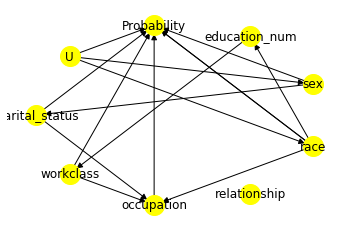

In [22]:
model.view_model()

In [23]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                             
───────(Expectation(Probability|marital_status,relationship,sex))
d[race]                                                          
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,marital_status,relationship,sex,U) = P(Probability|race,marital_status,relationship,sex)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [24]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                             
───────(Expectation(Probability|marital_status,relationship,sex))
d[race]                                                          
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,marital_status,relationship,sex,U) = P(Probability|race,marital_status,relationship,sex)

## Realized estimand
b: Probability~race+marital_status+relationship+sex
Target units: ate

## Estimate
Mean value: -0.05029719728220303

Causal Estimate is -0.05029719728220303


In [25]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                             
───────(Expectation(Probability|marital_status,relationship,sex))
d[race]                                                          
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,marital_status,relationship,sex,U) = P(Probability|race,marital_status,relationship,sex)

## Realized estimand
b: Probability~race+marital_status+relationship+sex
Target units: atc

## Estimate
Mean value: -0.04218615243134005

Causal Estimate is -0.04218615243134005


# Add Random Common Cause

In [26]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:-0.05029719728220303
New effect:-0.04154489016773779



# Replace Treatment with Placebo

In [27]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:-0.05029719728220303
New effect:-0.0006130211895271552
p value:0.45999999999999996



# Remove Random Subset of Data

In [28]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:-0.05029719728220303
New effect:-0.05019316405771523
p value:0.45999999999999996

